In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.animation as animation
from sklearn import datasets  # to retrieve the iris Dataset
import pandas as pd  # to load the dataframe
from sklearn.preprocessing import StandardScaler  # to standardize the features
from sklearn.decomposition import PCA  # to apply PCA
import seaborn as sns  # to plot the heat maps#float32
from numba import jit, cuda
from numba import jit, prange
import cv2

In [14]:
# Load spike data
#WF_data = np.load('data/data_WF_short.npy')
#WF_data = np.memmap('data/data_WF_resize_5k.npy',dtype ='float',mode='r', shape=(57600, 5000))
#WF_data = np.memmap('data/data_WF_resize_10k.npy',dtype ='int',mode='r', shape=(57600, 1000))
#wf_space_data_temp = np.memmap('data/svdSpatialComponents.npy', )
#WF_data = np.load('data/data_WF_resize_10k.npy')
WF_data = np.load('data/data_WF_resize_5k_norm.npy')

#WF_data_t = WF_data[:,10000:10999]
print(np.shape(WF_data))

W_short = np.array(WF_data[:,:1000])
w = np.array(WF_data[:,:5000])
# short time span
#t = np.shape(spike_data_t)[1]
#n = np.shape(spike_data)[0]data/data_WF_resize_5k
W = w.astype(np.float32)/10000 

(57600, 5000)


In [19]:
print(W[:,4000])
a = W[:,4500]
print(a.max())
print(a.min())

[ 0.e+00 -1.e-04  0.e+00 ... -1.e-04  0.e+00 -1.e-04]
0.0122
-0.0274


In [20]:

ims = a.reshape(240,240)
%matplotlib qt
plt.imshow(ims.T)
plt.show()

In [21]:
@jit(target_backend='cuda')
def scaling(a):
    #scalar = StandardScaler()
    #scaled_data = pd.DataFrame(scalar.fit_transform(a)) #scaling the data
    #print(scaled_data.shape)
    
    a = (a - np.mean(a,axis=0))/ np.std(a, axis = 0)

    #Applying PCA

    #Taking no. of Principal Components r
    #r = 500
    #pca = PCA(n_components = r)

    #data_pca = pca.fit_transform(a) # = US

    #c = pca.components_      # V
    #s = pca.singular_values_ # S

    return a

In [22]:
@jit(target_backend='cuda')
def scaling_numba(a):

    res = []
    for i in prange(a.shape[0]):
        res.append(a[i, :].mean())

    return np.array(res)


In [23]:
@jit(target_backend='cuda')
def scaling_numba1(a):

    mean = np.zeros((1,a.shape[1]))
    
    for j in prange(a.shape[1]):
        for i in prange(a.shape[0]):
            mean[0,j] = mean[0,j] + a[i,j]
        
        mean[0,j] = mean[0,j]/a.shape[0]
        
    std = np.zeros((1,a.shape[1]))
    for j in prange(a.shape[1]):
        for i in prange(a.shape[0]):
            std[0,j] = np.sqrt((a[i,j] - mean[0,j])**2/a.shape[0])
    
    for j in prange(a.shape[1]):
        a[:,j] = (a[:,j]-mean[0,j])/std[0,j]

    return a

In [26]:
#W_scaled = scaling(W_short)
#W_scaled = scaling(W)
W_scaled = scaling_numba1(W)

In [27]:
print(W_scaled.shape)
print(W_scaled[:,0])

(57600, 5000)
[240.      264.93118 240.      ... 240.      215.0688  240.     ]


In [28]:
@jit(target_backend='cuda')
def PCA_scale(a):
    #scalar = StandardScaler()
    #scaled_data = pd.DataFrame(scalar.fit_transform(a)) #scaling the data
    #print(scaled_data.shape)
    
    u, s, v = np.linalg.svd(a, full_matrices=False)

    #Applying PCA

    #Taking no. of Principal Components r
    #r = 500
    #pca = PCA(n_components = r)

    #data_pca = pca.fit_transform(a) # = US

    #c = pca.components_      # V
    #s = pca.singular_values_ # S

    return u,s,v

In [33]:
#[u,s,v] = PCA_scale(W)
[u,s,v] = PCA_scale(W_scaled)

(57600, 5000)
(5000,)
(5000, 5000)


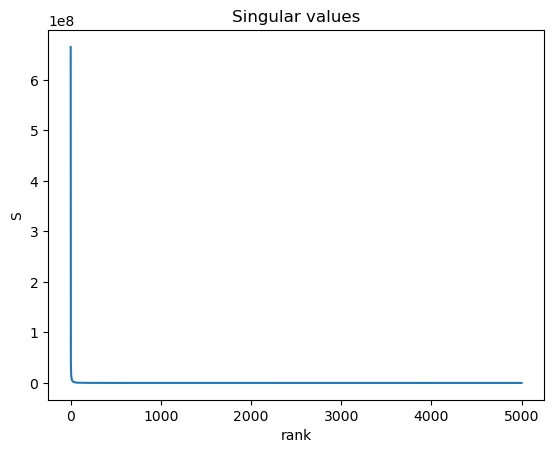

In [34]:
%matplotlib inline

print(u.shape)
print(s.shape)
print(v.shape)
fig, ax = plt.subplots()
ax.plot(s)

ax.set(xlabel='rank', ylabel='S',
       title='Singular values')
plt.show()

In [35]:
print(s[:100])

[6.65304000e+08 9.98488400e+07 4.00576400e+07 3.01316460e+07
 2.32100680e+07 1.69065480e+07 1.44520210e+07 1.40873060e+07
 1.13162090e+07 1.00449280e+07 7.99622300e+06 7.74674800e+06
 6.87323600e+06 5.92033250e+06 5.47235800e+06 5.25775000e+06
 4.94243000e+06 4.73606700e+06 4.21731650e+06 3.79821775e+06
 3.57919875e+06 3.38485050e+06 3.23119300e+06 3.10984850e+06
 2.93743675e+06 2.76405425e+06 2.63735100e+06 2.44747400e+06
 2.41815400e+06 2.25665150e+06 2.07243038e+06 2.03342162e+06
 1.82920762e+06 1.78079962e+06 1.70518388e+06 1.61911788e+06
 1.50858438e+06 1.49623638e+06 1.44688588e+06 1.40187362e+06
 1.32683375e+06 1.30140012e+06 1.25690188e+06 1.19329988e+06
 1.14416375e+06 1.06957462e+06 1.04108631e+06 1.00258394e+06
 9.92371938e+05 9.40430812e+05 9.14214500e+05 8.86113125e+05
 8.73583188e+05 8.28298125e+05 7.93013062e+05 7.80862188e+05
 7.65513438e+05 7.38720688e+05 7.26317125e+05 7.06659938e+05
 6.87459375e+05 6.64150250e+05 6.43808750e+05 6.29086312e+05
 6.22735375e+05 5.978415

In [36]:
# projection
r=20
u_r = u[:,:r]
s_r = s[:r]
S = np.diag(s_r)

#_proj = u_r.T@W_short
W_proj = u_r.T@W_scaled

#W_proj = np.linalg.inv(S)@u_r.T@W_short

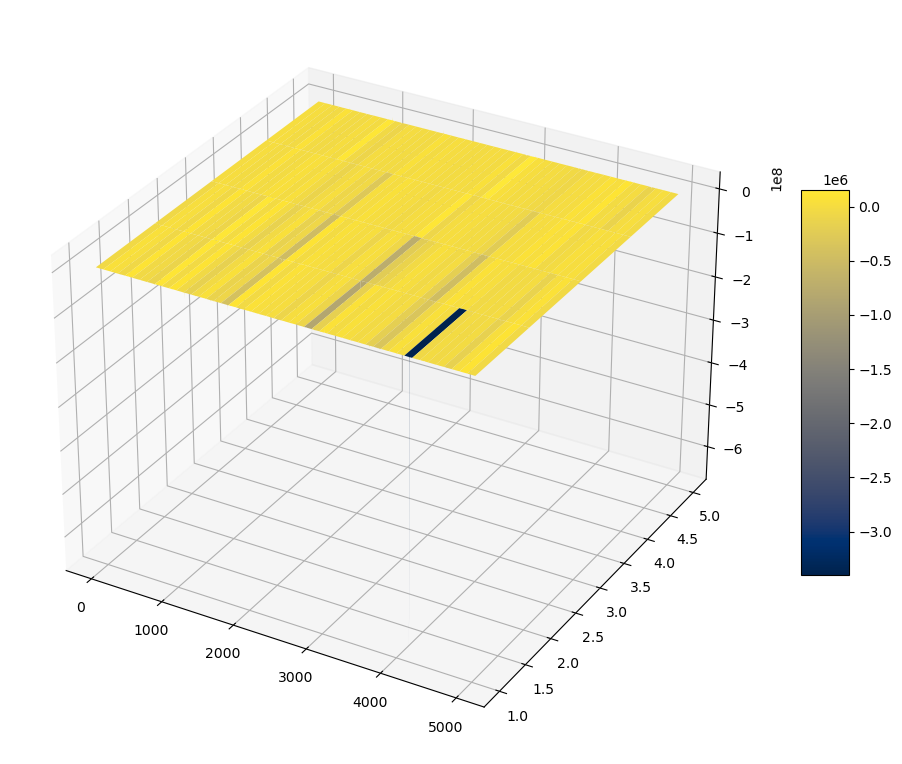

In [37]:
%matplotlib inline
dims=5
t=5000
time = np.linspace(1, t, t)
d = np.linspace(1, dims, dims)
T, N = np.meshgrid(time, d)

fig = plt.figure(figsize = (12,10))
ax = plt.axes(projection='3d')

surf = ax.plot_surface(T, N, W_proj[0:dims,:], cmap = plt.cm.cividis)
# Set axes label
#ax.set_xlabel('x', labelpad=20)
#ax.set_ylabel('y', labelpad=20)
#ax.set_zlabel('z', labelpad=20)

fig.colorbar(surf, shrink=0.5, aspect=8)

plt.show()

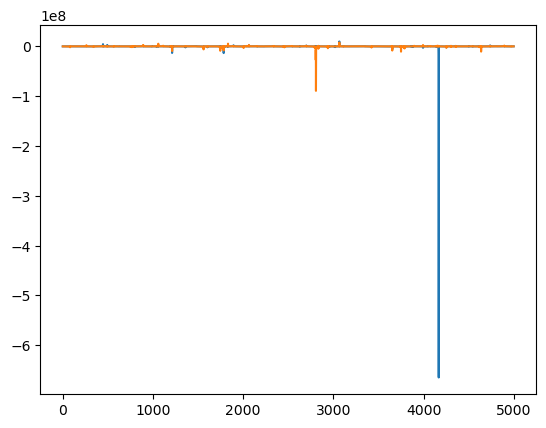

In [38]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(W_proj[:2,:].T)
plt.show()

In [ ]:
print(W_proj.shape)

In [ ]:
# reconstruction
@jit(target_backend='cuda')
def PCA_recon(a,u_r):
    
    U = u_r@u_r.T
    b = U@a



    return b